## Miami Plot
This is a small tutorial on performing a single Miami plot. I Miami plot is two Manhattan plots plotted opposite each other.

In [1]:
from skyline import (
    examples,
    plots,
    coords,
    figure,
    features
)
from skyline.tracks import labels
import pandas as pd

`matplotlib.backends.backend_agg` is required as some of the plotting components need access to a renderer to autosize text and the default figure creation does not seem to set this up, I am not sure why at the moment.

In [2]:
from matplotlib.backends import backend_agg

This is to display the plots within this notebook. Note that `%matplotlib notebook` does not implement any interactive plots. We have to use the display function to plot as we are not using `pyplot`. However, you can also use `matplotlib.figure.Figure.savefig` to save to file.

In [3]:
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline
from IPython.core.display import display

/tmp/ipykernel_97992/2058438933.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


### Get the example dataset

In [4]:
# Get the example data to plot and some labels for it
paired_gwas_labels = examples.get_data("paired_gwas_labels")
paired_gwas = examples.get_data("paired_gwas")

### Perform the basic plot

In [5]:
# The figure dimentions in inches and the DPI of our plot
figure_width = 4
figure_height = 2
figure_dpi = 150

In [6]:
# The coordinate transformer that will transform chr:pos into genomic coordinates
b37 = coords.HumanGRCh37()

In [7]:
# Initialise the figure
skyfig = figure.GenomicFigure(
    figsize=(figure_width, figure_height), dpi=figure_dpi
)
# AttributeError: 'FigureCanvasBase' object has no attribute 'get_renderer'
skyfig.set_canvas(backend_agg.FigureCanvas(figure=skyfig))

In [8]:
top_plot = paired_gwas[0]
bottom_plot = paired_gwas[1]

In [9]:
x = plots.miami(skyfig, top_plot, bottom_plot, b37)

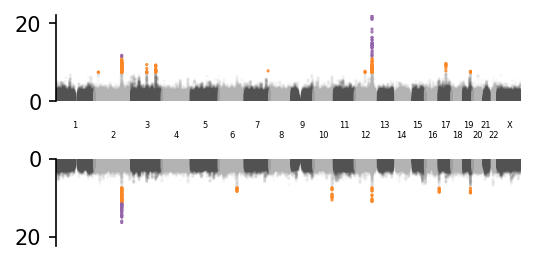

In [10]:
display(skyfig)

### Add some labels
We will create some dummy labels, one for each top hit on each chromosome over both the plots.

In [11]:
label_data = pd.concat(
    [top_plot, bottom_plot]
).sort_values(['chr_name', 'pvalue'], ascending=False).\
drop_duplicates('chr_name')

We supply the labels to the Miami plot in `skyline.labels.FeatureCoords` objects, these specify where the label is, the text and any custom styling parameters.

In [12]:
label_data = [
    features.FeatureCoords(
        i.chr_name, i.start_pos,
        label="C{0}:{1}".format(i.chr_name, i.start_pos)
    ) for i in label_data.itertuples(index=False)
]

In [13]:
# Increase the height to account for the labels
figure_height = 4

In [14]:
# Initialise the figure
skyfig = figure.GenomicFigure(
    figsize=(figure_width, figure_height), dpi=figure_dpi
)
# AttributeError: 'FigureCanvasBase' object has no attribute 'get_renderer'
skyfig.set_canvas(backend_agg.FigureCanvas(figure=skyfig))

Now we will replot. We give the miami plot the label data. We also adjust the line_style and make the drop lines thinner (note any adjustments are merged with the defaults). As the chromsome labels were taking up too much space, we also make that smaller. If we set it to 0 it will turn them off entirely. 

In [15]:
# Give the miami plot the label data and make the drop lines thinner
# Also make the space used by the chromosome labels smaller
x = plots.miami(
    skyfig, top_plot, bottom_plot, b37, label_data=label_data,
    line_style=dict(linewidth=0.5), chr_label_length=1
)

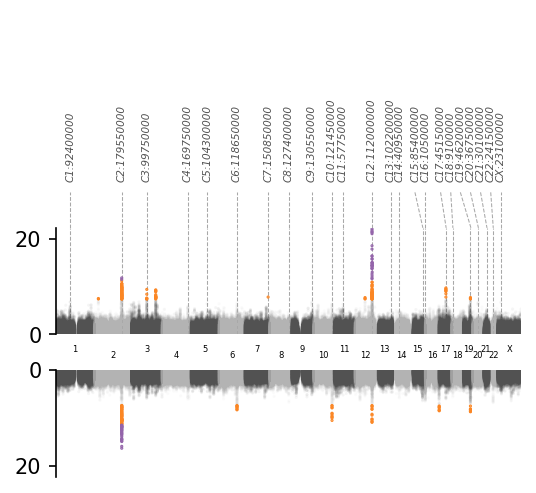

In [16]:
display(skyfig)

### Customising the plot
So we have seen some of the basics for producing a single Miami plot. However, as we get access to all the matplotlib features then we can customise it some more. For example, imagine if we want to move the chromosome labels from the middle to the bottom and have the two scatter plots back-to-back. For this, we can set the `chr_label_length` to 0, to remove. However, currently there is no option to automaticaly add them to the end, for that we will need to drop into the low level API and make more use of nested gridspecs.

First lets demonstrate the removal of the chromosome labels.

In [17]:
skyfig.clear()
# Give the miami plot the label data and make the drop lines thinner
# Also make the space used by the chromosome labels smaller
x = plots.miami(
    skyfig, top_plot, bottom_plot, b37, label_data=label_data,
    line_style=dict(linewidth=0.5), chr_label_length=0
)
display(skyfig)

Now to add them below the plot we will use nested gridspecs. For this, we need to think about the relative amount of space we want to use for them. In the original plots, we allowed a single row for them with 3 rows for each scatter plot, 5 for the labels and 2 for the label linkers (these are the defaults). So this means 1/14 rows, so we will go with that again.

In [18]:
from matplotlib import gridspec

In [19]:
spec = gridspec.GridSpec(nrows=14, ncols=1)

Now we want 13 of those rows for the plot and 1 for the chromosome labels

In [20]:
subspec = spec[:13]

In [21]:
skyfig.clear()
# Give the miami plot the label data and make the drop lines thinner
# Also make the space used by the chromosome labels smaller
x = plots.miami(
    skyfig, top_plot, bottom_plot, b37, label_data=label_data,
    line_style=dict(linewidth=0.5), chr_label_length=0,
    tracks=subspec
)

The chromosome labels is a lower level API call directly to a class that inherits from `matplotlib.Axes`, we give it the single row to use for it's plotting space. 

In [22]:
chrlab = labels.ChrLabels(skyfig, spec[13:], b37, rows=3)
skyfig.add_track(chrlab)

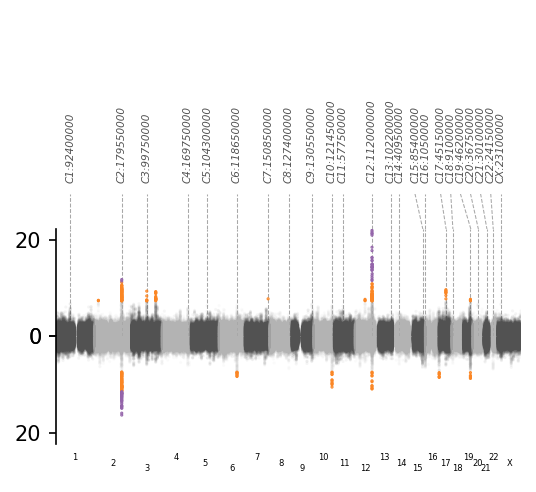

In [23]:
display(skyfig)

### Multiple Miami plots
We can extend the usage of sub-plot-specs even further to allow the creation of multiple Miami plots. In this case we want to add the labels, lines and chromosomes independently of the Miami plotting function. This is a bit more work but is not too bad.

So we create a gridspec with enough space for two miami plots, one above the other, our labels, linker track and chromosomes. So, if we follow a similar process to above, that is 12 rows for both scatter plots, 1 for the linker and 5 for the labels, however, this time we will go for 2 for the chromsomes, so 20 in all. 

In [24]:
spec = gridspec.GridSpec(nrows=20, ncols=1)

As the labels and the linker will be at the very top of the plot, we want to pre-allocate space for our two Miami plots after them

In [25]:
subspec = spec[7:18]

Now let us do a quick test to see if we are looking good

In [26]:
subgrid = gridspec.GridSpecFromSubplotSpec(2, 1, subspec)

In [27]:
skyfig.clear()
for idx, i in enumerate(range(0, 4, 2)):
    x = plots.miami(
        skyfig, paired_gwas[i], paired_gwas[i+1], b37,
        line_style=dict(linewidth=0.5), chr_label_length=0,
        tracks=subgrid[idx]
    )

So, we can see our two Miami plots stacked one on top of the other, just as we wanted. They look a bit squashed as we are still using the figure dimentions from above, we will change that in the finsihed plot below. To explain the code above a bit more. We selected rows 7-13 to hold our Miami plots (`subspec`), we then used that pre-allocated area and created another Grid on it (`subgrid`), of two rows, this makes it easier to simply plot a Miami in each row, we could, in theory also set a bigger gap between the plots when creating `subgrid`.

In the `for` loop, we are looping through the paired GWAS 2-by-2 and using `enumerate` to control the row to plot the Miami on. You will notice though, that the two Miami plots have occupied all the space even though we only selected a subset of all the possible rows, this is a `matplotlib` thing and if we had added stuff to those rows then it would appear in the plot.

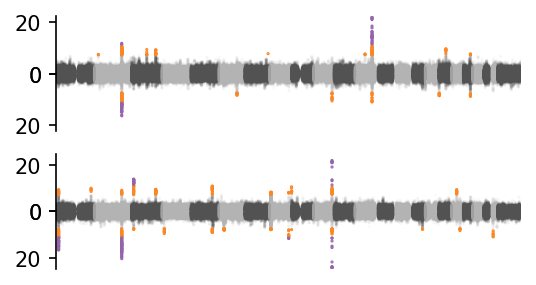

In [28]:
display(skyfig)

#### The final plot
So now we will go ahead and plot the whole thing. we start by clearing the figure used in the previous plot and importing some of the low level plotting components that will be used in our plot, namely, ``labels`` and ``linkers``.

In [29]:
skyfig.clear()

In [30]:
from skyline.tracks import (
    labels, linkers
)
from skyline import styles

We will re-generate the label data in a similar way to above, however, this time we will use input data from the first 4 datasets that we will plot.

In [31]:
label_data = pd.concat(paired_gwas[0:4]).sort_values(['chr_name', 'pvalue'], ascending=False).drop_duplicates('chr_name')

In [32]:
label_data = [
    features.FeatureCoords(
        i.chr_name, i.start_pos,
        label="C{0}:{1}".format(i.chr_name, i.start_pos)
    ) for i in label_data.itertuples(index=False)
]

For this we don't have to really re-create the spec but we will just so all the code is in one place.

In [33]:
spec = gridspec.GridSpec(nrows=20, ncols=1)

Now we will create the label track and give it the first 5 rows, then add it to our figure.

In [34]:
label_track = labels.Labels(skyfig, spec[:6], b37, label_data)
skyfig.add_track(label_track)

We create the linker track from the label track plotting coordinates, in a similar way to labels using `skyline.labels.LabelCoords` objects, the linker track uses, `skyline.linkers.LinkerCoords` obejcts to describe the link positions and their styles (if needed).

In [35]:
links = []
for i, j in label_track.label_plot_coords:
    links.append(linkers.LinkCoords(i, j))

We use the `LinkerCoords` in the linker track and you will notice we are passing the adjusted thinner linker style to the `LineLinkerTrack`

In [36]:
linker_track = linkers.LineLinkerTrack(
    skyfig, spec[6:7], b37, links, linker_style=dict(linewidth=0.5)
)
skyfig.add_track(linker_track)

Now we will eventually create the Miami plots and add the chromsome labels in a similar way to before, however, before we do we want to create the linker drop lines, these are lines that will traverse the whole scatter plot area and will allow a visual comparison of similar peaks across the plots.

In [37]:
# Will hold the scatter plots and drop lines
subspec = spec[7:18]

In [38]:
drop_lines = linkers.BlankTrack(skyfig, subspec, b37)

# All skyline Axes have this method to create vertical lines from linker objects
# Also make sure our adjusted line width is used 
drop_lines.axvlines_from_linker(links, bottom_cap=True, linewidth=0.5)
skyfig.add_track(drop_lines)

In [39]:
subgrid = gridspec.GridSpecFromSubplotSpec(2, 1, subspec, wspace=0, hspace=0)

In [40]:
for idx, i in enumerate(range(0, 4, 2)):
    x = plots.miami(
        skyfig, paired_gwas[i], paired_gwas[i+1], b37,
        chr_label_length=0,
        tracks=subgrid[idx]
    )

In [41]:
chrlab = labels.ChrLabels(skyfig, spec[18:], b37, rows=2)
skyfig.add_track(chrlab)

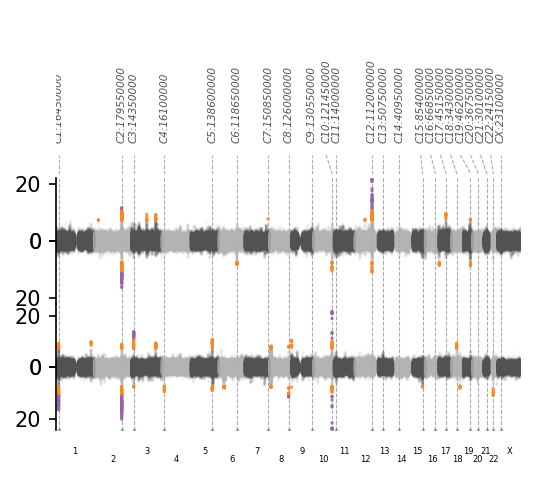

In [42]:
display(skyfig)

So now we have seen some more advanced using of the lower level API components. We can see that in the plot above the left label is slightly off the plot, we could add some `xpad` if needed, however, the same xpad would need to be added to all the components of the plot. Eventually, there will be higher level functions for make of the steps outlined above.